# Spam generation

## Installation & setup

In [1]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, GPT2LMHeadModel

## Tokenizer

In [2]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [3]:
tokenizer_config = {
  'padding': 'max_length',
  'truncation': True,
  'max_length': 128,
  'return_tensors': 'pt'
}

## Dataset

https://huggingface.co/datasets/TrainingDataPro/email-spam-classification

In [7]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
from datasets import load_dataset

dataset = load_dataset("TrainingDataPro/email-spam-classification")

test_size = 0.2

if 'train' in dataset:
    dataset_split = dataset['train'].train_test_split(test_size=test_size)
else:
    raise ValueError("The dataset does not have a train split.")

train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

README.md:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

email_spam.csv:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/84 [00:00<?, ? examples/s]

Number of training samples: 67
Number of testing samples: 17


In [10]:
SPAM_LABEL = 'spam'
NO_SPAM_LABEL = 'not spam'

SPAM_LABEL_2_ID_MAP = {
    NO_SPAM_LABEL: 0,
    SPAM_LABEL: 1
}

SPAM_ID_2_LABEL_MAP = {
    0: NO_SPAM_LABEL,
    1: SPAM_LABEL
}

In [63]:
def map_function(item):
    return {
        'type': item['type'],
        'text': item['text'],
        'title': item['title'],
        'label': float(SPAM_LABEL_2_ID_MAP[item['type']])
    }

train_dataset = train_dataset.map(map_function)
test_dataset = test_dataset.map(map_function)

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

In [64]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## GAN

The GAN model is inspired by TextGail:
- code: https://github.com/qywu/TextGAIL/tree/master,
- article: https://arxiv.org/pdf/2004.13796.

### Generator

In [85]:
class TextGenerator(nn.Module):
  def __init__(self, max_new_tokens=128):
    super(TextGenerator, self).__init__()

    self.max_new_tokens = max_new_tokens
    self.model = GPT2LMHeadModel.from_pretrained('gpt2')

  def forward(self, inputs):
    return self.model.generate(
        **inputs,
        max_new_tokens=self.max_new_tokens,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

#### On hold: RNN

Simple text generation model from https://www.kaggle.com/code/ab971631/beginners-guide-to-text-generation-pytorch

Useful links:
- https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/6.%20Natural-Language-Processing/8.%20Natural%20Language%20Generation/text-generation-via-rnn-and-lstms-pytorch.ipynb

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        if hidden is None:  # Initialize hidden state if not provided
            hidden = self.init_hidden()
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

### Discriminator 1 - Spam classifier

In [45]:
class SpamDiscriminator(nn.Module):
  def __init__(self, num_labels=2):
    super(SpamDiscriminator, self).__init__()

    self.model = RobertaModel.from_pretrained('roberta-base')
    self.classifier = nn.Linear(self.model.config.hidden_size, 1)

  def forward(self, inputs):
    outputs = self.model(**inputs)

    # Use the hidden states of the [CLS] token for classification
    cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token

    logits = self.classifier(cls_output)
    prob = torch.sigmoid(logits)
    return prob

In [46]:
input_text = "Congratulations! You've won a $1,000 Walmart gift card."

inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

model = SpamDiscriminator()

model.eval()
with torch.no_grad():
    prob = model(inputs).item()

threshold = 0.5
predicted_class = 1 if prob >= threshold else 0

print(f"Probability of spam: {prob:.4f}, predicted class: {SPAM_ID_2_LABEL_MAP[predicted_class]}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Probability of spam: 0.4505, predicted class: not spam


### Discriminator 2 - Detector of generated text

In [47]:
class AiGeneratedDiscriminator(nn.Module):
  def __init__(self, num_labels=2):
    super(AiGeneratedDiscriminator, self).__init__()

    self.model = RobertaModel.from_pretrained('roberta-base')
    self.classifier = nn.Linear(self.model.config.hidden_size, 1)

  def forward(self, inputs):
    outputs = self.model(**inputs)

    # Use the hidden states of the [CLS] token for classification
    cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token

    logits = self.classifier(cls_output)
    prob = torch.sigmoid(logits)
    return prob

In [49]:
input_text = "Congratulations! You've won a $1,000 Walmart gift card."

inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

model = SpamDiscriminator()

model.eval()
with torch.no_grad():
    prob = model(inputs).item()

print(f"Probability of the text being generated by AI: {prob:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Probability of the text being generated by AI: 0.5989


## Training setup

In [86]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models

generator = TextGenerator().to(device)
discriminator_A = SpamDiscriminator().to(device)
discriminator_B = AiGeneratedDiscriminator().to(device)

# Optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=0.001)
optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=0.001)

# Loss function

criterion = nn.BCELoss()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training loop  

In [88]:
from tqdm import tqdm

num_epochs = 5

losses = {
    'generator': [],
    'spam_discriminator': [],
    'ai_discriminator': []
}

for epoch in range(num_epochs):
  print(f"\nEpoch {epoch + 1}...\n")
  for batch in tqdm(train_loader):
      text_tokenized = tokenizer(batch['text'], **tokenizer_config).to(device)
      title_tokenized = tokenizer(batch['title'], **tokenizer_config).to(device)
      labels = batch['label'].float().to(device)

      fake_text = generator(title_tokenized).to(device) # Generate text corpus for given titles

      # Train Discriminator A - Spam detector
      optimizer_D_A.zero_grad()
      output_A_real = discriminator_A(text_tokenized)
      output_A_fake = discriminator_A({'input_ids': fake_text})
      loss_D_A = criterion(output_A_real.view(-1).float().to(device), labels) + \
                  criterion(output_A_fake.view(-1).float().to(device), torch.ones(batch_size).float().to(device))
      loss_D_A.backward()
      optimizer_D_A.step()

      # Train Discriminator B - AI-Generated text detector
      optimizer_D_B.zero_grad()
      output_B_real = discriminator_B(text_tokenized)
      output_B_fake = discriminator_B({'input_ids': fake_text})
      loss_D_B = criterion(output_B_real.view(-1).float().to(device), torch.zeros(batch_size).float().to(device)) + \
                  criterion(output_B_fake.view(-1).float().to(device), torch.ones(batch_size).float().to(device))
      loss_D_B.backward()
      optimizer_D_B.step()

      # Train Generator
      optimizer_G.zero_grad()
      output_A_fake = discriminator_A({'input_ids': fake_text})
      output_B_fake = discriminator_B({'input_ids': fake_text})
      loss_G = criterion(output_A_fake.view(-1).to(device), torch.zeros(batch_size).to(device)) + \
                criterion(output_B_fake.view(-1).to(device), torch.zeros(batch_size).to(device))
      loss_G.backward()
      optimizer_G.step()

  losses['generator'].append(loss_G.item())
  losses['spam_discriminator'].append(loss_D_A.item())
  losses['ai_discriminator'].append(loss_D_B.item())

  print(f'\nEpoch [{epoch + 1}/{num_epochs}], Loss D_A: {loss_D_A.item()}, Loss D_B: {loss_D_B.item()}, Loss G: {loss_G.item()}')


Epoch 1...



100%|██████████| 4/4 [00:21<00:00,  5.29s/it]



Epoch [1/5], Loss D_A: 1.4776617288589478, Loss D_B: 1.378448486328125, Loss G: 1.9925429821014404

Epoch 2...



100%|██████████| 4/4 [00:19<00:00,  4.95s/it]



Epoch [2/5], Loss D_A: 1.103624701499939, Loss D_B: 2.071122169494629, Loss G: 2.131225347518921

Epoch 3...



100%|██████████| 4/4 [00:22<00:00,  5.64s/it]



Epoch [3/5], Loss D_A: 1.4039651155471802, Loss D_B: 3.3196046352386475, Loss G: 1.7454465627670288

Epoch 4...



100%|██████████| 4/4 [00:18<00:00,  4.69s/it]



Epoch [4/5], Loss D_A: 1.2906360626220703, Loss D_B: 1.3973602056503296, Loss G: 2.288647413253784

Epoch 5...



100%|██████████| 4/4 [00:18<00:00,  4.70s/it]



Epoch [5/5], Loss D_A: 0.7318751215934753, Loss D_B: 1.4347442388534546, Loss G: 3.0984106063842773


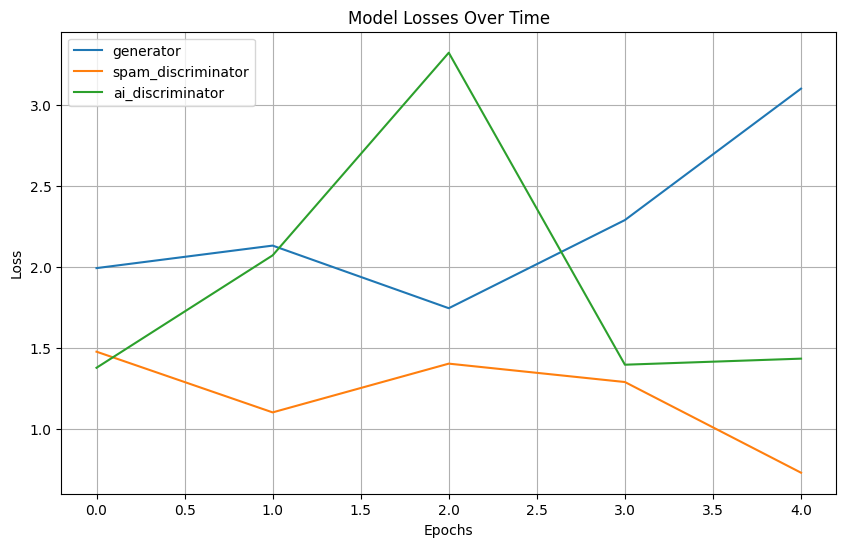

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for key, value in losses.items():
    plt.plot(value, label=key)

plt.title('Model Losses Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.ylim(0, 1)  # Adjust y-axis limit if necessary

plt.show()

## Test

In [91]:
example_title = "AFE Model Casting Call"

inputs = tokenizer(example_title, return_tensors='pt', padding=True, truncation=True)

generated = generator(inputs.to(device))

In [92]:
decoded_output = tokenizer.decode(generated[0], skip_special_tokens=True)

print(decoded_output)

AFE Model Casting Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on


## TODO

***NB: Please make a copy of this notebook before doing any changes***

**Part 1 - Can be done now in parallel**

- Find larger dataset or find ways to augment the existing dataset

Dataset specification (each item of the dataset should be in the following format):
```
{
        'text': string,
        'title': string
        'label': 0 (not spam) or 1 (spam)
}
```

If you find a dataset not coressponding to this format, please use mapping.

- Find metrics to evaluate the richness and realness of the generated text, preferably we will include this into the loss function of the generator

- Experiment with architectures of generator. This network takes as an input a title of a spam email and generates email body (text). The generator can be also unconditional, e.g. not taking anything as input and just generating random text of a spam email

- Experiment with architectures of the AI generated detector. This network takes as an input a tokenized text and returns a probability [0, 1] that this text is AI generated

- Experiment with architectures of the Spam classifier. This network takes as an input a tokenized text and returns a probability [0, 1] that this text is spam

**Part 2: TODO after Part 1**

- Pre-train Spam classifier

- Pre-train Detector of the generated text

**Part 3: TODO after Part 2**

- Fine-tune GAN training. For example, experiment with different learning rates for discriminators and generator